In [73]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

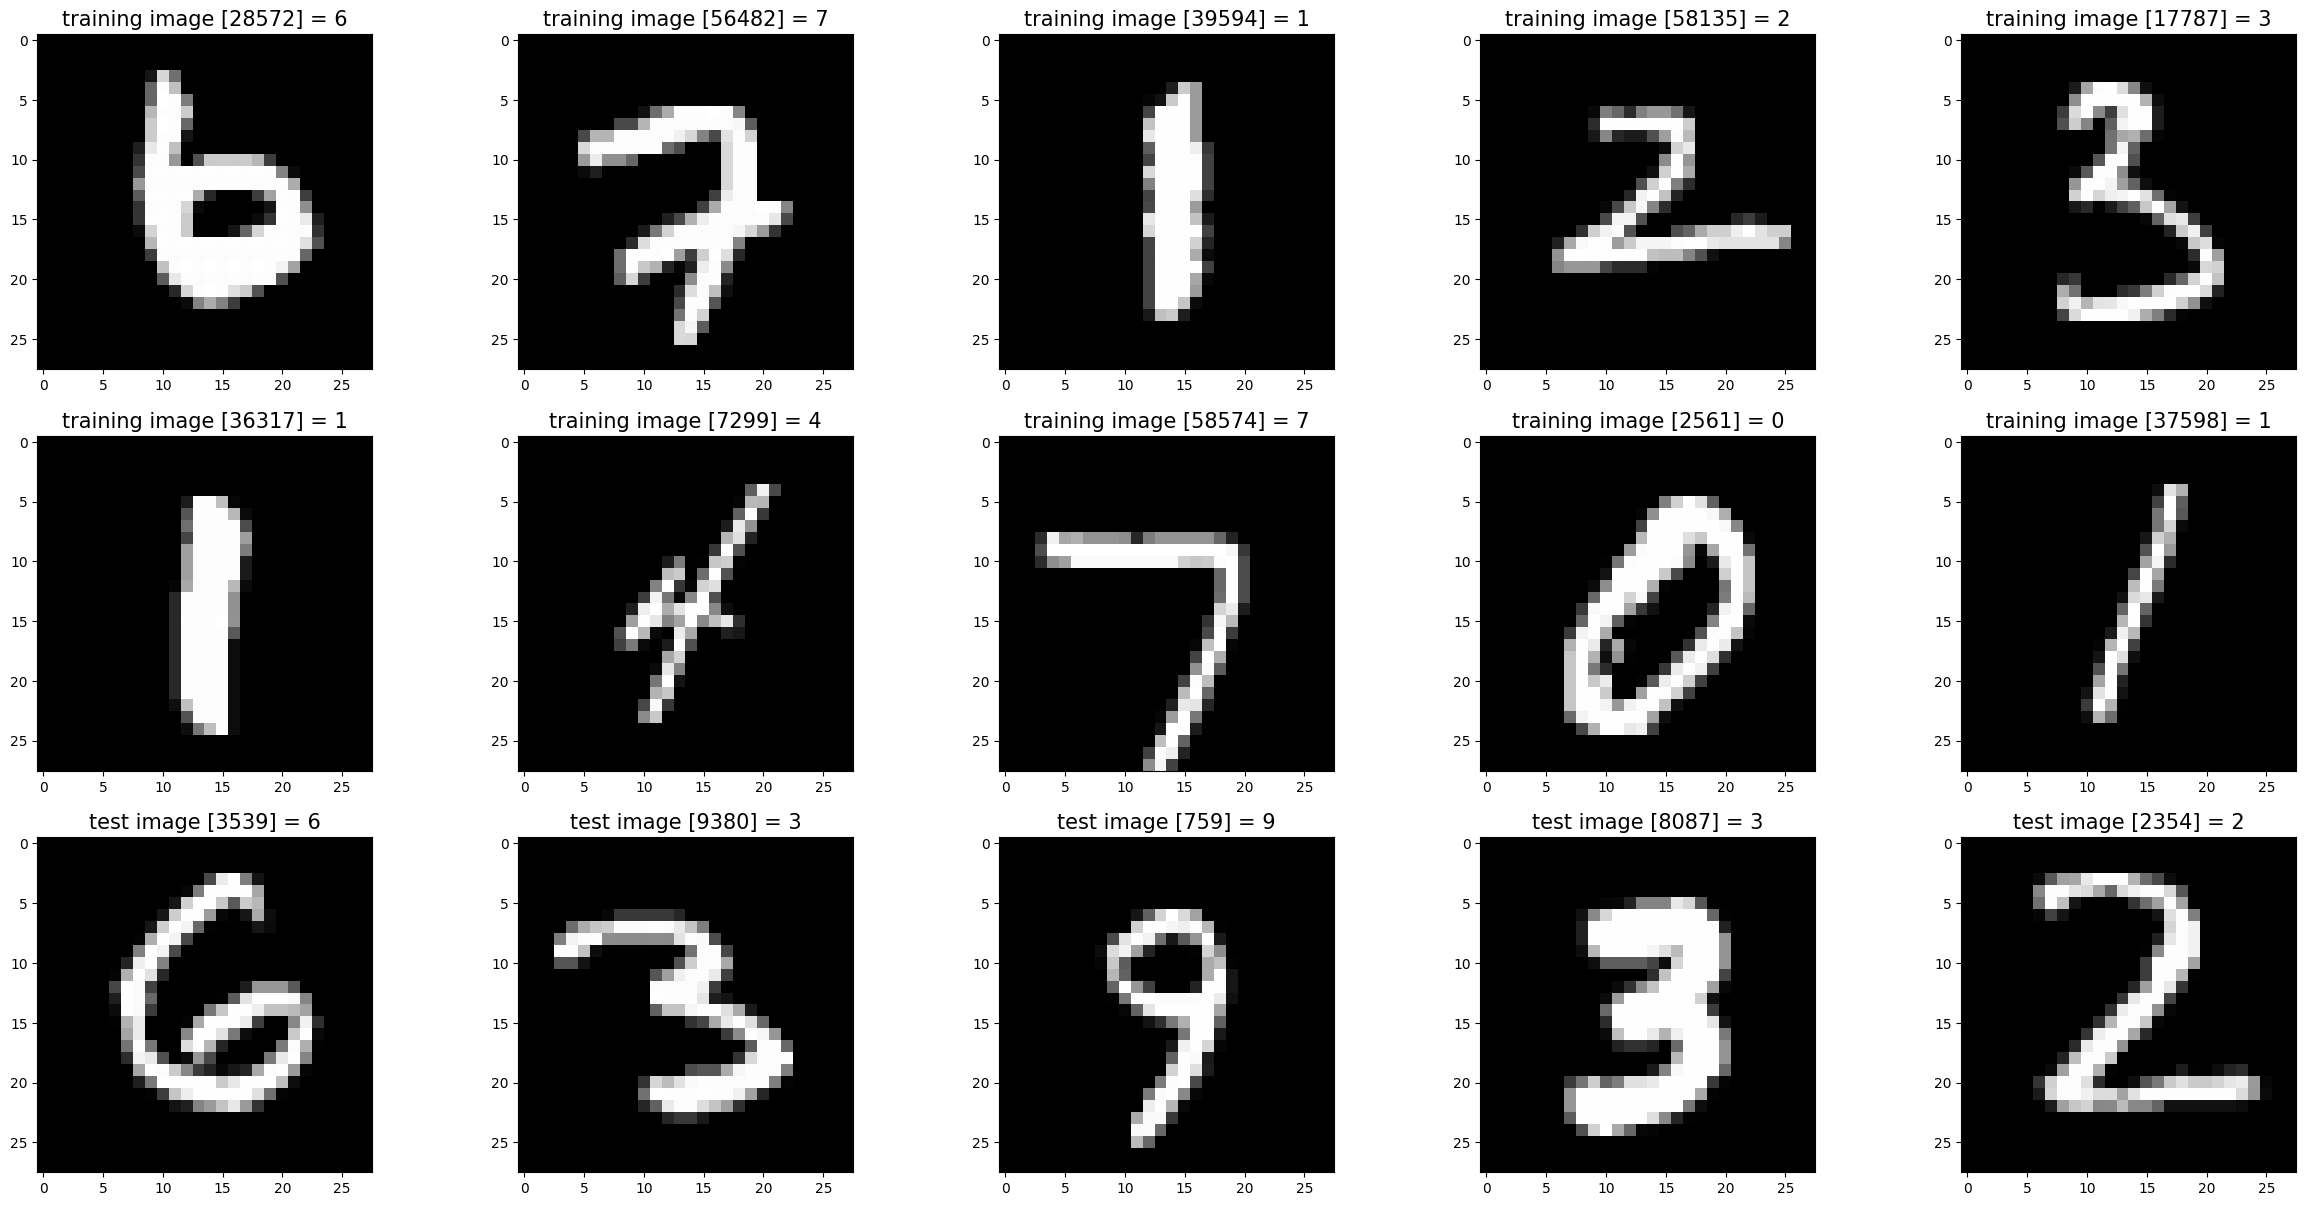

In [74]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '../1-NN-prototype-algo'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [81]:

import numpy as np
import random
from sklearn.metrics import pairwise_distances_argmin_min

def custom_kmeans(X, n_clusters, max_iters=100, random_state=42):
    np.random.seed(random_state)
    
    # Randomly initialize cluster centers
    n_samples, n_features = X.shape
    indices = np.random.choice(n_samples, n_clusters, replace=False)
    cluster_centers = X[indices]
    
    for _ in range(max_iters):
        # Assigning each data point to the nearest cluster center
        labels = pairwise_distances_argmin_min(X, cluster_centers)[0]
        
        # Updating cluster centers
        new_centers = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
        
        # Checking for convergence
        if np.allclose(cluster_centers, new_centers):
            break
        
        cluster_centers = new_centers
    
    return cluster_centers, labels

def select_prototypes_kmeans_scratch(x_train, y_train, num_prototypes):
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    # Flatten images we have
    x_flat = np.array([img.flatten() for img in x_train])
    
    print(f"Training data shape: {x_train.shape}")
    print(f"Flattened data shape: {x_flat.shape}")
    print(f"Number of prototypes requested: {num_prototypes}")
    
    # Perform custom K-means clustering
    cluster_centers, _ = custom_kmeans(x_flat, n_clusters=min(num_prototypes, len(x_train)))
    
    # Finding closest points to cluster centers (prototypes)
    prototype_indices = []
    for center in cluster_centers:
        # Finding the training point closest to each cluster center
        distances = np.linalg.norm(x_flat - center, axis=1)
        closest_idx = np.argmin(distances)
        prototype_indices.append(closest_idx)
    
    # Selecting prototype images and labels
    prototype_images = x_train[prototype_indices]
    prototype_labels = y_train[prototype_indices]
    
    print(f"Prototype images shape: {prototype_images.shape}")
    print(f"Prototype labels shape: {prototype_labels.shape}")
    
    return prototype_images, prototype_labels

def custom_1nn_classifier_scratch(test_image, prototypes, prototype_labels):
    # Ensure float64 conversion is considered
    test_image_flat = test_image.flatten().astype(np.float64)
    prototype_flat = np.array([img.flatten().astype(np.float64) for img in prototypes])
    
    # Calculating distances
    distances = np.linalg.norm(prototype_flat - test_image_flat, axis=1)
    
    # Finding nearest prototype
    nearest_idx = np.argmin(distances)
    
    return prototype_labels[nearest_idx]

def evaluate_prototype_selection_scratch(x_train, y_train, x_test, y_test, num_prototypes):
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    # Selecting prototypes using custom K-means
    prototypes, prototype_labels = select_prototypes_kmeans_scratch(
        x_train, y_train, num_prototypes
    )
    
    # Predicting labels for test set
    predictions = []
    for test_image in x_test:
        pred = custom_1nn_classifier_scratch(test_image, prototypes, prototype_labels)
        predictions.append(pred)
    
    # Calculating accuracy
    accuracy = np.mean(np.array(predictions) == y_test)
    
    print(f"Unique training labels: {np.unique(y_train)}")
    print(f"Unique prototype labels: {np.unique(prototype_labels)}")
    print(f"Unique prediction labels: {np.unique(predictions)}")
    
    return accuracy, prototypes, prototype_labels

In [86]:
def uniform_random_selection(x_train, y_train, num_prototypes):
    indices = np.random.choice(len(x_train), num_prototypes, replace=False)
    return x_train[indices], y_train[indices]

def evaluate_prototype_selection(x_train, y_train, x_test, y_test, num_prototypes, method='kmeans'):
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    
    if method == 'kmeans':
        prototypes, prototype_labels = select_prototypes_kmeans_scratch(
            x_train, y_train, num_prototypes
        )
    elif method == 'random':
        prototypes, prototype_labels = uniform_random_selection(
            x_train, y_train, num_prototypes
        )
    
    # Predicting labels for test set
    predictions = []
    for test_image in x_test:
        pred = custom_1nn_classifier_scratch(test_image, prototypes, prototype_labels)
        predictions.append(pred)
    
    # Calculating accuracy
    accuracy = np.mean(np.array(predictions) == y_test)
    
    return accuracy

# Experimenting with the parameters
num_prototypes_list = [1000, 5000, 10000]

# Storing results
results_kmeans = {M: [] for M in num_prototypes_list}
results_random = {M: [] for M in num_prototypes_list}

# Run experiments
for M in num_prototypes_list:
    # K-means selection method
    accuracy_kmeans = evaluate_prototype_selection(x_train, y_train, x_test, y_test, M, method='kmeans')
    results_kmeans[M].append(accuracy_kmeans)
    
    # Random selection method
    accuracy_random = evaluate_prototype_selection(x_train, y_train, x_test, y_test, M, method='random')
    results_random[M].append(accuracy_random)

# Calculate mean and confidence intervals and then plotting them in the report
def calculate_confidence_interval(accuracies, confidence=0.95):
    mean_accuracy = np.mean(accuracies)
    std_dev = np.std(accuracies)
    margin_of_error = 1.96 * (std_dev / np.sqrt(len(accuracies)))  # 1.96 for 95% confidence
    return mean_accuracy, margin_of_error

results_summary = {
    'kmeans': {M: calculate_confidence_interval(results_kmeans[M]) for M in num_prototypes_list},
    'random': {M: calculate_confidence_interval(results_random[M]) for M in num_prototypes_list}
}

# Printing the results
for M in num_prototypes_list:
    print(f"M = {M}")
    print(f"K-means: Mean Accuracy = {results_summary['kmeans'][M][0]:.4f}, Confidence Interval = ±{results_summary['kmeans'][M][1]:.4f}")
    print(f"Random: Mean Accuracy = {results_summary['random'][M][0]:.4f}, Confidence Interval = ±{results_summary['random'][M][1]:.4f}")
    print()

Training data shape: (60000, 28, 28)
Flattened data shape: (60000, 784)
Number of prototypes requested: 1000
Prototype images shape: (1000, 28, 28)
Prototype labels shape: (1000,)
Training data shape: (60000, 28, 28)
Flattened data shape: (60000, 784)
Number of prototypes requested: 5000
Prototype images shape: (5000, 28, 28)
Prototype labels shape: (5000,)
Training data shape: (60000, 28, 28)
Flattened data shape: (60000, 784)
Number of prototypes requested: 10000
Prototype images shape: (10000, 28, 28)
Prototype labels shape: (10000,)
M = 1000
K-means: Mean Accuracy = 0.9230, Confidence Interval = ±0.0000
Random: Mean Accuracy = 0.8817, Confidence Interval = ±0.0000

M = 5000
K-means: Mean Accuracy = 0.9447, Confidence Interval = ±0.0000
Random: Mean Accuracy = 0.9360, Confidence Interval = ±0.0000

M = 10000
K-means: Mean Accuracy = 0.9500, Confidence Interval = ±0.0000
Random: Mean Accuracy = 0.9497, Confidence Interval = ±0.0000



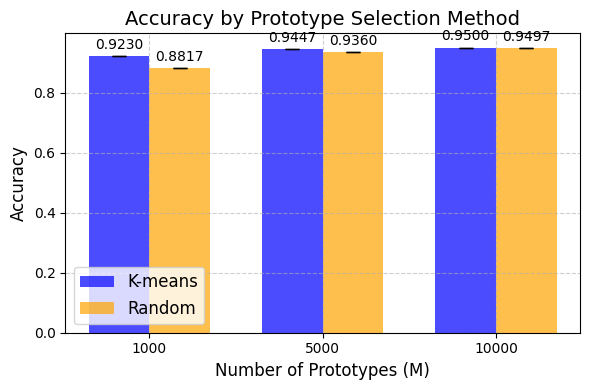

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values dynamically
M_values = num_prototypes_list
kmeans_means = [results_summary['kmeans'][M][0] for M in M_values]
kmeans_errors = [results_summary['kmeans'][M][1] for M in M_values]
random_means = [results_summary['random'][M][0] for M in M_values]
random_errors = [results_summary['random'][M][1] for M in M_values]

# Plotting
x = np.arange(len(M_values))  # X-axis positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(6, 4))

# Plot K-means results
rects1 = ax.bar(x - width/2, kmeans_means, width, yerr=kmeans_errors, label='K-means', color='blue', alpha=0.7, capsize=5)

# Plot Random results
rects2 = ax.bar(x + width/2, random_means, width, yerr=random_errors, label='Random', color='orange', alpha=0.7, capsize=5)

# Add labels, title, and legend
ax.set_xlabel('Number of Prototypes (M)', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy by Prototype Selection Method', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(M_values)
ax.legend(fontsize=12)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Add data labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

add_labels(rects1)
add_labels(rects2)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()